In [32]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

import mu_avg.mu_avg as mu_avg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data, calculate vtms

In [2]:
%%time
fp_interp_df = helper.root_to_pandas(range(3959,3995), prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=False)
tr_interp_df_1 = helper.root_to_pandas([3956], prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=True)
tr_interp_df_2 = helper.root_to_pandas([3997], prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=True)

Reading event 154050/154052 100.00%                                                                                 
loop done: 100%                                    
Reading event 8780/8781 99.99%      
loop done: 100%                                    
Reading event 2630/2634 99.85%  
loop done: 100%                                    
Reading event 8730/8735 99.94%          
loop done: 100%                                    
Reading event 2610/2619 99.66% 
loop done: 100%                                    
CPU times: user 56.8 s, sys: 4.36 s, total: 1min 1s
Wall time: 2min 1s


In [3]:
%%time
fp_moment_df = helper.calc_moment_df(fp_interp_df)
tr_moment_df_1 = helper.calc_moment_df(tr_interp_df_1)
tr_moment_df_2 = helper.calc_moment_df(tr_interp_df_2)

Finished calculating all moments for 257281 events.   
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4363 events.
CPU times: user 18.4 s, sys: 39.7 s, total: 58.2 s
Wall time: 8.75 s


In [4]:
%%time
tr_corr_df_1 = helper_old.trolley_footprint_replacement(tr_moment_df_1)
tr_corr_df_2 = helper_old.trolley_footprint_replacement(tr_moment_df_2)

Removing trolley image from station 71.CPU times: user 7.28 s, sys: 4.33 s, total: 11.6 s 
Wall time: 5.76 s



In [5]:
%%time
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper_old.trolley_run_station_average(tr_corr_df_1)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper_old.trolley_run_station_average(tr_corr_df_2)

CPU times: user 381 ms, sys: 40 ms, total: 421 ms
Wall time: 377 ms


In [6]:
%%time
vtm_df = helper.vtm_calc(fp_moment_df,
                         baseline_time_1, baseline_time_2,
                         tr_baseline_1, tr_baseline_2,
                         fp_baseline_1, fp_baseline_2)

CPU times: user 7.73 s, sys: 15.6 s, total: 23.4 s
Wall time: 3.67 s


In [ ]:
azi_avg_df = pd.DataFrame(np.zeros((vtm_df.shape[0],6)),
                         index = vtm_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = (summed_azimuth_1[:, m] + summed_azimuth_2[:, m])
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = vtm_df[stm_list].multiply(weight).sum(axis=1)/total_weight
print_df = azi_avg_df[['m1','m2','m3','m5']].copy()/61.79

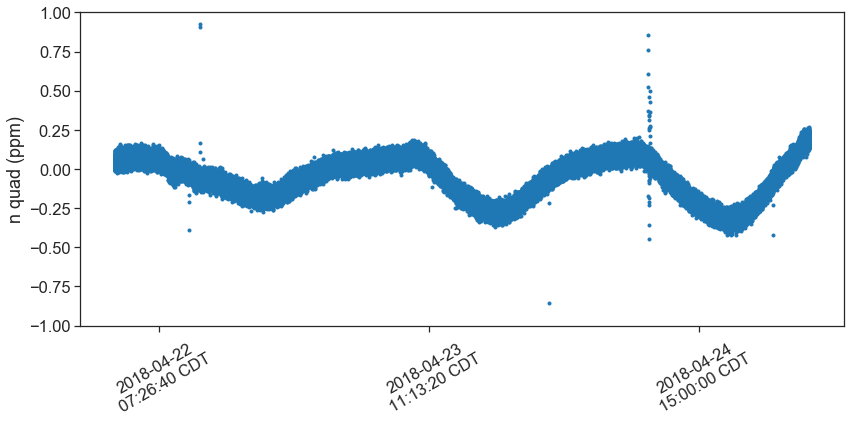

In [11]:
plt.plot(print_df.index.values, print_df['m2'], '.')
# plt.xlim((1528650000, 1529000000))
# plt.ylim(840,843)
plt.ylim(-1,1)
ax = plt.gca()
fig = plt.gcf()

ax.set_ylabel('n quad (ppm)')
plt2.plt_unix_time_to_CST(ax)

fig.set_size_inches(12,6)
fig.tight_layout()

# Time and azimuthal averaging

## Read in ctags and $\omega_a$ subrun status for time averaging

In [12]:
### Read in ctag info

subrun_df = pd.read_hdf('old_hdf5/60hr_subrun.h5', key='ctag')
usable_subruns_df = subrun_df[subrun_df['ok']==True].copy()

### Bin by subrun

intervals = []
interval_centers = []
interval_range = []
for ii in range(usable_subruns_df['end_gps'].values.size):
    intervals.append(pd.Interval(usable_subruns_df['start_gps'].values[ii],
                                 usable_subruns_df['end_gps'].values[ii],
                                 closed='both'
                                )
                    )
    interval_centers.append((usable_subruns_df['start_gps'].values[ii] + usable_subruns_df['end_gps'].values[ii])/2)
    interval_range.append(usable_subruns_df['end_gps'].values[ii] - usable_subruns_df['start_gps'].values[ii])
    
intervals = pd.IntervalIndex(intervals)
interval_centers = np.array(interval_centers)
interval_range = np.array(interval_range)

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, intervals)).mean()
vtm_bin_df['bin_range'] = interval_range
vtm_bin_df['start_gps'] = usable_subruns_df['start_gps'].values

vtm_bin_df = vtm_bin_df.merge(usable_subruns_df[['start_gps', 'ctags']])
vtm_bin_df.index = interval_centers

In [13]:
subrun_df.head()

,run,subrun,start_time,end_time,start_gps,end_gps,ctags,t0val,fills,quad_condition,...,fillcuts_ok,field_ok,trolley_period,field_period,ctags_loose_ok,quad_loose_ok,ctags_repeat_ok,losses_repeat_ok,fillcuts_repeat_ok,ok
0,15921,0,1.524421e+09,1.524421e+09,1.524421e+09,1.524421e+09,0,0.0,0,12.1/18.0,...,False,True,0.0,1.0,False,None,None,None,None,False
1,15921,1,1.524421e+09,1.524421e+09,1.524421e+09,1.524421e+09,0,0.0,0,13.1/18.0,...,False,True,0.0,1.0,False,None,None,None,None,False
2,15921,2,1.524421e+09,1.524421e+09,1.524421e+09,1.524421e+09,0,0.0,0,13.1/18.0,...,False,True,0.0,1.0,False,None,None,None,None,False
3,15921,3,1.524421e+09,1.524421e+09,1.524421e+09,1.524421e+09,0,0.0,0,13.1/18.0,...,False,True,0.0,1.0,False,None,None,None,None,False
4,15921,4,1.524421e+09,1.524421e+09,1.524421e+09,1.524421e+09,0,0.0,0,13.1/18.0,...,False,True,0.0,1.0,False,None,None,None,None,False


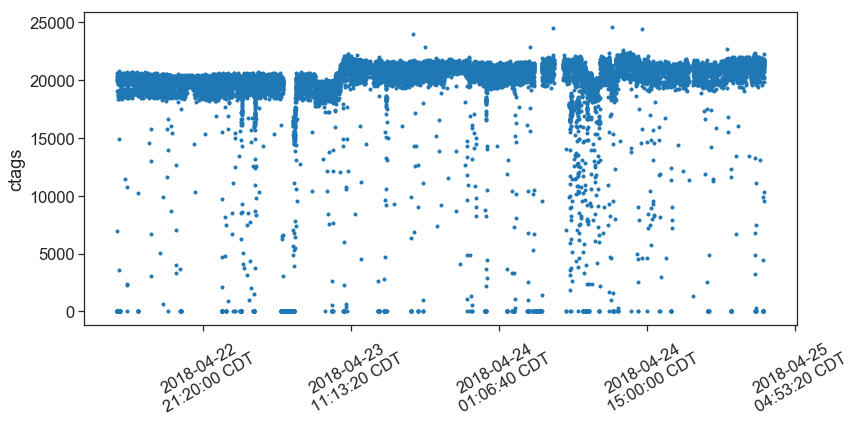

In [17]:
fig, ax = plt.subplots(1,1)

ax.plot(subrun_df['start_gps'].values, subrun_df['ctags'].values, '.')

plt2.plt_unix_time_to_CST(ax)
ax.set_ylabel('ctags')

fig.set_size_inches(12,6)
fig.tight_layout()

## Time average, weighted by ctags in "ok" subruns

In [18]:
stms = ['st'+str(st)+',m'+str(m+1) for st in range(72) for m in range(6)]
time_avg_series = vtm_bin_df[stms].multiply(vtm_bin_df['ctags'], axis='index').sum()/vtm_bin_df['ctags'].sum()

In [19]:
time_avg_series

st0,m1     51534.263041
st0,m2        94.645332
st0,m3       -84.789369
st0,m4       -36.697723
st0,m5        11.832090
st0,m6      -964.957513
st1,m1     50339.672609
st1,m2        41.576758
st1,m3        48.036227
st1,m4       363.344950
st1,m5      -118.502929
st1,m6      3271.302040
st2,m1     50420.164689
st2,m2       -56.201657
st2,m3        40.205057
st2,m4       863.537906
st2,m5       -41.528029
st2,m6      -800.026060
st3,m1     51643.901232
st3,m2      -189.076892
st3,m3      -198.658765
st3,m4       560.337594
st3,m5      -382.473488
st3,m6      9174.010181
st4,m1     52374.169190
st4,m2     -1687.491341
st4,m3      -652.917695
st4,m4       -24.325037
st4,m5     -1611.257976
st4,m6       914.621288
               ...     
st67,m1    51733.629886
st67,m2       98.823585
st67,m3       84.024492
st67,m4       13.504317
st67,m5      -72.916345
st67,m6     2887.304934
st68,m1    51463.120408
st68,m2       65.884969
st68,m3      -27.094760
st68,m4     -300.221399
st68,m5      -80

## Naive azimuthal average, weighted by fixed probe station extent

In [20]:
azi_avg_series = pd.Series(index = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m]
    
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_series['m'+str(m+1)] = time_avg_series[stm_list].multiply(weight).sum()/total_weight

In [107]:
## naive 2D integral

def _2D_field_map(x,y):  # in mm
    
    m1 = azi_avg_series[0]
    m2 = azi_avg_series[1]
    m3 = azi_avg_series[2]
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    
    return m1 + m2*r/45*np.cos(phi) + m3*r/45*np.sin(phi)


In [112]:
def _2D_average_integrand(x,y):
    f = _2D_field_map(x,y)
    g = mu_avg._xy_dist(x, y, 1, 19.4, 45.9, -0.17, 13.5)
    R = 7112 + x
    return R*f*g

def _2D_dist_integrand(x,y):
    return mu_avg._xy_dist(x, y, 1, 19.4, 45.9, -0.17, 13.5)*(7112 + x)

In [113]:
%%time

opts = {'epsrel':1.0e-3}

num_short = scipy.integrate.nquad(_2D_average_integrand, [[-60,60],[-60,60]], opts=opts)
den_short = scipy.integrate.nquad(_2D_dist_integrand, [[-60,60],[-60,60]], opts=opts)

CPU times: user 298 ms, sys: 28 ms, total: 326 ms
Wall time: 290 ms


In [117]:
print num_short
print den_short

print num_short[0]/den_short[0]/61.79

(370036994.20209384, 0.49846662941854447)
(7118.135906334689, 9.595674516305053e-06)
841.318954774


In [118]:
print (azi_avg_series[0] + 19.4/45 * azi_avg_series[1] - 0.17/45 *azi_avg_series[2])/61.79

841.293856537046


## Analytic form for field  (through m3)

In [28]:
st_phis = np.array(trfp.STATION_BARCODE_PHI)
st_phis[0:3] -= 360

st_phis = np.append(st_phis, [st_phis[0]+360])
print st_phis

[ -9.83  -5.67  -1.16   4.34   9.33  14.23  20.2   23.32  29.33  34.33
  39.33  43.31  50.2   53.31  59.34  64.33  69.34  73.3   80.17  83.32
  89.31  94.33  99.31 103.3  110.19 113.31 119.34 124.32 129.3  133.27
 140.21 143.38 149.34 154.33 159.36 163.31 170.19 173.39 179.36 184.35
 189.36 193.31 200.17 203.38 209.34 214.31 219.34 223.32 230.22 233.42
 239.36 244.34 249.38 253.34 260.2  263.47 269.35 274.34 279.38 283.41
 290.19 293.37 299.34 304.31 309.34 313.29 320.19 323.41 329.33 334.35
 339.35 343.41 350.17]


In [84]:
st_phis = np.array(trfp.STATION_BARCODE_PHI)
st_phis[0:3] -= 360
st_phis = np.append(st_phis, [st_phis[0]+360])
st_phis = st_phis/180*pi

stms = ['st'+str(st)+',m1' for st in range(72)]
m1s = np.append(time_avg_series[stms].values,time_avg_series[stms].values[0])

stms = ['st'+str(st)+',m2' for st in range(72)]
m2s = np.append(time_avg_series[stms].values,time_avg_series[stms].values[0])

stms = ['st'+str(st)+',m3' for st in range(72)]
m3s = np.append(time_avg_series[stms].values,time_avg_series[stms].values[0])

def _xy_field(x, y, m1, m2, m3):  # assume inputs are in mm, fields in Hz
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    
    return m1 + m2*r/45*np.cos(phi) + m3*r/45*np.sin(phi)

_m1 = scipy.interpolate.CubicSpline(st_phis, m1s, bc_type='periodic')
_m2 = scipy.interpolate.CubicSpline(st_phis, m2s, bc_type='periodic')
_m3 = scipy.interpolate.CubicSpline(st_phis, m3s, bc_type='periodic')

def _field_map(x, y, theta):  # inputs are in mm and radians
    m1 = _m1(theta)
    m2 = _m2(theta)
    m3 = _m3(theta)
    return _xy_field(x, y, m1, m2, m3)

In [85]:
_field_map(2,2,180)

52673.47260516275

In [86]:
_field_map(20,20,pi)

51302.016749898314

In [87]:
pi = np.pi

def average_integrand(x, y, theta):  # takes x, y in mm, theta in rad    
    return _field_map(x, y, theta) * mu_avg._xyz_integrand(x, y, theta, 1)

def dist_integrand(x, y, theta): # takes x, y in mm, theta in rad
    return mu_avg._xyz_integrand(x, y, theta, 1)

In [92]:
%%time
## took ~1 minute
opts = {'epsrel':1.0e-6}
numerator = scipy.integrate.nquad(_field_map, [[-60.,60.],[-60.,60.],[0,2*pi]], opts=opts)

print numerator

(4704395674.1353245, 9955.250369579833)
CPU times: user 1min 1s, sys: 2.81 s, total: 1min 4s
Wall time: 59.7 s


In [101]:
%%time
## took
opts = {'epsrel':1.0e-3}
numerator2 = scipy.integrate.nquad(average_integrand, [[-60,60],[-60,60],[0,2*pi]], opts=opts)

print numerator2

(52038.203015520274, 41.38570667365731)
CPU times: user 3min 46s, sys: 10.4 s, total: 3min 56s
Wall time: 3min 37s


In [95]:
%%time
## took ~15 minutes
opts = {'epsrel':1.0e-6}
numerator = scipy.integrate.nquad(average_integrand, [[-60,60],[-60,60],[0,2*pi]], opts=opts)

print numerator

(52038.1868777148, 0.10715501321376159)
CPU times: user 16min 8s, sys: 43.3 s, total: 16min 52s
Wall time: 15min 30s


In [90]:
%%time
## took ~10 sec
denominator = scipy.integrate.nquad(dist_integrand, [[-60.,60.],[-60.,60.],[0,2*pi]])

print denominator

(1.000843782249345, 1.4853437684643574e-08)
CPU times: user 11.3 s, sys: 657 ms, total: 11.9 s
Wall time: 10.8 s


In [100]:
print (numerator[0]/denominator[0])/61.79

841.46811778


In [88]:
%%time
## takes ~10 seconds

print scipy.integrate.nquad(mu_avg._xyz_integrand, [[-60,60],[-60,60],[0,2*np.pi]], args=[1])

(1.000843782249345, 1.4853437684643574e-08)
CPU times: user 11.4 s, sys: 641 ms, total: 12.1 s
Wall time: 11 s


# Legacy code/studies

## Alan studies

In [ ]:
import allantools

fig, ax = plt.subplots(1,1)
for st in range(7):
    stm = 'st'+str(st)+',m1'
    tau, adev, _, _ = allantools.mdev(fp_moment_df[stm].values/61.79, data_type='freq', taus='decade')
    plt.loglog(tau, adev, '.', label=stm)
plt.legend()
fig.set_size_inches(12,8)
fig.tight_layout()

## Sync Offsets

In [ ]:
sync_offsets, delta_t = helper.sync_offset_calc(tr_corr_df_1, tr_corr_df_2)

def gaussian(x, A, x0, sigma): return A*np.exp(-(x-x0)**2/2./sigma**2)

fig, axs = plt.subplots(2,3)
for i in range(2):
    for j in range(3):
        st = 3*i+j
        if st == 5: continue
            
        plt.sca(axs[i,j])
        hist, bins, _ = plt.hist(sync_offsets[:,st], bins=50)
        low, high = axs[i,j].get_xlim()
                
        bins = bins[0:-1] + 0.5*(bins[1]-bins[0])
        coeffs, _ = curve_fit(gaussian, bins, hist, p0=[1., 0., 10.])
        fit = gaussian(np.arange(low, high, 0.1), coeffs[0], coeffs[1], coeffs[2])
        plt.plot(np.arange(low,high,0.1), fit, label=r'$\omega_0$ = '+str(np.round(coeffs[1],1))+'\n$\sigma$ = '+str(np.round(coeffs[2],1)))
        plt.legend(loc=1)
        plt2.plt_set_labels(axs[i,j], 'sync offset (Hz)', '', 'm '+str(st+1))
        
        if st == 0: plt.xlim(-100,100)
        else: plt.xlim(-50,50)


fig.set_size_inches(12,8)
fig.tight_layout()

## Extended trolley averages

In [ ]:
# calculate extended trolley averages

print np.sum(tr_baseline_1*summed_azimuth_1, axis=0)/360

print '\n'

print np.sum(tr_baseline_2*summed_azimuth_2, axis=0)/360

## Legacy time/azimuthal averaging

In [ ]:
### Bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500  # bin edges
bin_centers = np.arange(1524384055, 1524640055, 1000)

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bins)).mean()
vtm_bin_df.index = bin_centers

test_df = vtm_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m]
    
    # de-weight station 5 (split into 4 and 6 by distance to each)
    weight[4] += weight[5] * (trfp.STATION_BARCODE_PHI[6]-trfp.STATION_BARCODE_PHI[5])/(trfp.STATION_BARCODE_PHI[6]-trfp.STATION_BARCODE_PHI[4])
    weight[6] += weight[5] * (trfp.STATION_BARCODE_PHI[5]-trfp.STATION_BARCODE_PHI[4])/(trfp.STATION_BARCODE_PHI[6]-trfp.STATION_BARCODE_PHI[4])
    weight[5] = 0
    
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight
    
print_df = azi_avg_df[['m1','m2','m3','m5']].copy()/61.79
print_df['m1_err'] = 0.116
print_df['m2_err'] = 0.06
print_df['m3_err'] = 0.06
print_df['m5_err'] = 0.1

print_df = print_df.sort_index(axis='columns')
# print_df.head()
# print_df.to_csv('purcell_60hr_7-31.csv')

In [ ]:
# print all stations

fig, axs = plt.subplots(24,3)

for i in range(24):
    for j in range(3):
        plt.sca(axs[i,j])
        st = i*3 + j
        plt.plot(vtm_bin_df.index.values, vtm_bin_df['st'+str(st)+',m5']/61.79, '.', markersize=1, color='navy')
        plt2.plt_set_labels(axs[i,j], '', 'NS (ppm)', 'st '+str(st))
        plt2.plt_unix_time_to_CST(axs[i,j])

fig.set_size_inches(16, 80)
fig.tight_layout()

## Compare with Rachel

In [ ]:
rachel_m1 = np.loadtxt('rachel_m1_st135.txt')

fig, axs = plt.subplots(24,3)

for i in range(24):
    for j in range(3):
        plt.sca(axs[i,j])
        st = i*3 + j
#         if st == 71: continue
        plt.plot(vtm_bin_df.index.values, vtm_bin_df['st'+str(st)+',m1']/61.79 - rachel_m1[:,st], '.', markersize=1, color='navy')
        plt2.plt_set_labels(axs[i,j], '', 'Dipole (ppm)', 'st '+str(st))
        plt2.plt_unix_time_to_CST(axs[i,j])

fig.set_size_inches(16, 80)
fig.tight_layout()